# 1 Introduction

Ho: there are 5 positions to account for every player (PG, SG, SF, PF, C)

Ha: the 5 position model is outdated and players fall into a more robust role distribution

## 1.0.1 Imports

Import libraries and write settings.

In [136]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter("ignore", UserWarning)

import pandas as pd
pd.set_option('mode.chained_assignment', None)

# import sklearn
from sklearn import cluster, metrics, datasets
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [137]:
from matplotlib import rcParams
import matplotlib as mpl

blue = '#3498DB'
gray = '#95A5A6'
red = '#E74C3C'
dark_gray = '#34495E'
green = '#2ECC71'
purple = '#9B59B6'
flatui = [blue, gray, red, dark_gray, green, purple]

# Patches
mpl.rc('patch', 
       linewidth=0.5, 
       facecolor=dark_gray, 
       edgecolor='w', 
       force_edgecolor=True, 
       antialiased=True)    
  
# Figure
mpl.rc('figure', 
       figsize= (10, 6),
       facecolor='w', 
       edgecolor='w', 
       titlesize='xx-large',
       titleweight=700)

# Grid
mpl.rc('grid', 
       color=dark_gray,
       alpha=0.5, 
       linewidth=0.5, 
       linestyle='-')

# Axes
mpl.rc('axes', 
       facecolor='w',
       edgecolor=dark_gray,
       linewidth=0.5,
       grid=True,
       titlesize='large',
       labelsize='large',
       labelcolor=dark_gray,
       axisbelow=True)

mpl.rc('axes.spines',
       right=False,
       top=False)

# Ticks
mpl.rc('xtick', 
       direction='out',
       color=dark_gray)

mpl.rc('xtick.major', 
       size=0.0)

mpl.rc('xtick.minor', 
       size=0.0)

mpl.rc('ytick', 
       direction='out',
       color=dark_gray)

mpl.rc('ytick.major', 
       size=0.0)

mpl.rc('ytick.minor', 
       size=0.0)

mpl.rc('legend', 
       frameon=False,
       numpoints=1,
       scatterpoints=1)

mpl.rc('font', 
       size=13,
       weight=400,
       family='sans-serif')

rcParams['font.sans-serif']: ['Helvetica', 'Verdana', 'Lucida Grande']

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# 1.1 Data

read in data

"Basketball on Paper: Rules and Tools for Performance Analysis" by Dean Oliver

[Calculating Individual Offensive and Defensive Ratings](https://www.basketball-reference.com/about/ratings.html "Basketball-Reference.com")

In [138]:
# full_per_100 contains 'per 100 possessions' player stats, importantly controlling for usage rate.
# if I player doesn't receive as many minutes but has good stats per 100 possessions, there may be
# an issue of being undervalued there

players = pd.read_csv("data/interim/full_per_100_player_data.csv")
players.drop('Unnamed: 0', axis = 1, inplace = True)

# 2 Exploratory Data Analysis

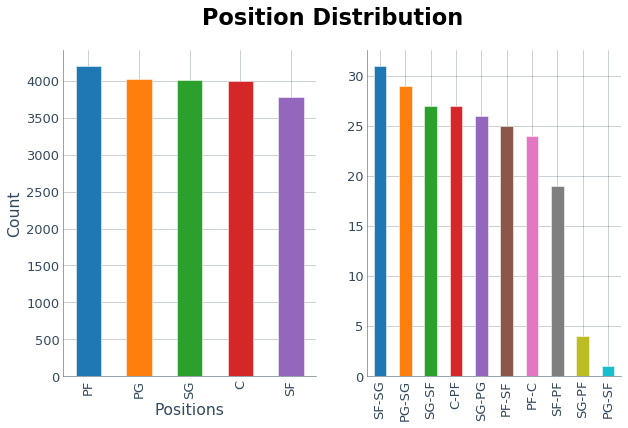

In [28]:
a = players['Pos'].value_counts()[:5]
b = players['Pos'].value_counts()[5:]

plt.subplots(nrows = 1, ncols = 2)
plt.subplot(1,2,1)
a.plot(kind = 'bar')
plt.xlabel('Positions')
plt.ylabel('Count')
#plt.title('Position Distribution')
plt.subplot(1,2,2)
b.plot(kind = 'bar')
plt.suptitle('Position Distribution')
plt.show()

The right chart above gives frequncies of players who have held multiple positions across one season. In every case, the players were only listed at multiple positions because they played for multiple teams in that season and the unique teams listed the player at different positions. If, for example, a player was listed as PG for one team, was traded to another and they used him as a shooting guard (SG), our data would have that player listed as having team 'TOT' for total and his position as 'PG-SG'. These players make up a minority of our data, of course, but give further legitimacy to our hypothesis that player positions ought not be considered hard and fast as simply point guard through center.

# 3 Linear Discriminant Analysis and Principal Component Analysis

Explain differences and importance of each here.

### 3.0.1 Data Preprocessing

In [139]:
scal = 10     # 'scal' for 'starter-calibre', where scal will signify 10 or more games
# started; played with this number until I got 50% of the player base
# (only the years 2000 - 2017 have all features available)

# we only have salary data for players from years 2000 onward, so we'll cluster those players:

full = players[players.Year > 1999]

full = full.groupby('Full Name', sort=False).mean().reset_index().set_index('Full Name')

full = full.apply(lambda x: x.fillna(x.mean()),axis=0)

pos = players[players.Year > 1999].groupby('Full Name', sort=False).Pos.first()
full['Pos'] = pos

starters = full[full.GS >= scal]

# some of these features don't need to influence the clustering, so they'll be dropped

data = starters.drop(['Age', 'Year', 'G', 'GS', 'MP', 'salary'], axis=1)

# worth considering that we might not want composite stats influencing the clustering
# LDA won't distinguish these features from the components of these features
# BPM in particular seems to be a garbage stat--let's throw that out as well.

data = data.drop(['OBPM', 'DBPM', 'BPM', 'PER', 'OWS',
                  'DWS', 'VORP', 'WS', 'WS/48', 'USG%'], axis=1)

# strategically drop features that reduce variance

data = data.drop(['Heaves_A', 'Heaves_Md', 'FG', 'FT', 'FTA', '3P', '3P%',
                  'FT%', '2P', '2P%', 'TOV%', 'PF', 'ORB%', 'DRB%', 'TRB%',
                  'STL%', 'AST%', 'BLK%', 'FG%'], axis=1)

# X will be distinct from 'data' in the absence of old player position (PG, SG, SF, PF, or C)
# y will be just that old player position data

X = data.drop('Pos', axis=1)
y = data.loc[:,'Pos']

print('With a floor metric of', scal, 'games played for the season,we can \nlook at', len(starters),
      'out of', len(full), 'possible players in between', int(min(starters.Year)), 'and', int(max(starters.Year)))
print('--a sample of', round(len(starters)/len(full), 2)
      * 100, '% of the players available. \n')

With a floor metric of 10 games played for the season,we can 
look at 724 out of 1720 possible players in between 2000 and 2018
--a sample of 42.0 % of the players available. 



In [140]:
print(len(data.columns))
data.columns

34


Index(['FGA', '3PA', '2PA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'ORtg', 'DRtg', 'TS%', '3PAr', 'FTr', 'Dist.', '2P_A', '0-3_A', '3-10_A', '10-16_A', '16-3pt_A', '3P_A', '0-3%', '3-10%', '10-16%', '16-3pt%', 'Astd_2P', 'Dunk%', 'Dunks_Md', 'Astd_3P', '%Corner3_A', 'Corner_3P%', 'Pos'], dtype='object')

In [141]:
# scale the data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 3.1 Dimensionality Reduction (PCA vs LDA)

Right away we see that controlling for games started gives us a more appropriate number of players to consider (a nice clean 500).

In [142]:
# Dimensionality Reduction with PCA

pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Cumulative Explained Variance using PCA:",
      round(pca.explained_variance_ratio_.sum(), 3))

Cumulative Explained Variance using PCA: 0.466


In [143]:
# Dimentionality Reduction with LDA, RDA, QDA

LDA = LinearDiscriminantAnalysis(
    n_components=2, shrinkage='auto', solver='eigen')

LDA_reduced_df = LDA.fit(X_scaled, y).transform(X_scaled)

print("Mean accuracy on the given test data and labels with LDA:",
      LDA.score(X_scaled, y))

Mean accuracy on the given test data and labels with LDA: 0.7196132596685083


**LDA explanation here.** Linear Discriminant Analysis (LDA) is a a method used in statistics and machine learning to find a linear combination of features that characterizes or separates classes of objects. Put simply, LDA attempts to find a feature subspace that maximizes class separability. In this case, I used a player’s current position (i.e. point guard, shooting guard, small forward, power forward, and center) as the prior class. Next LDA found the linear combination of features that best separated the five classes and reduced the dimensions of the data into two dimensions. While Principal Component Analysis (PCA) is also a method for dimensionality reduction, I captured 67.8% of the data in two components with LDA while only capturing 46.3% of the data in two components with PCA.

## 3.2 KMeans Clustering

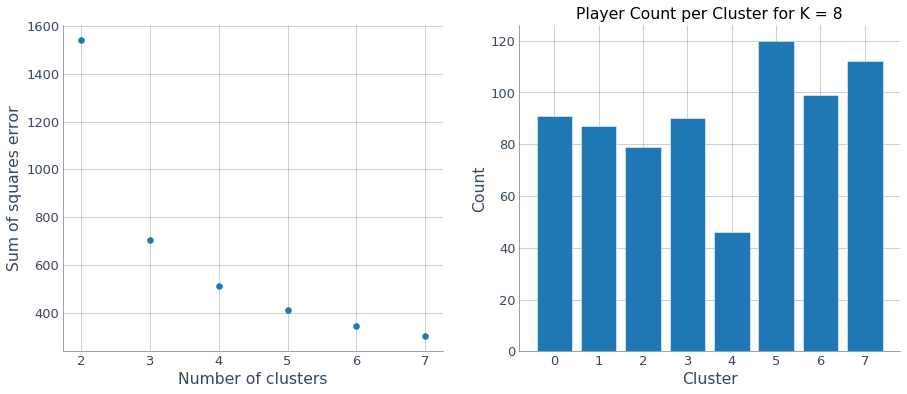

In [155]:
# proposed cluster count, variable 'n'

n = 8

SS = []

for k in range(2, n):
    kmeans_cluster = KMeans(n_clusters=k, random_state=23).fit(LDA_reduced_df)
    SS.append(kmeans_cluster.inertia_)

plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

plt.subplot(121)
plt.scatter(range(2, n), SS)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squares error")

plt.subplot(122)

kmeans_cluster = KMeans(n_clusters=n, random_state=23).fit(LDA_reduced_df)

counts = [0 for i in range(n)]
for i in range(n):
    for label in kmeans_cluster.labels_:
        if label == i:
            counts[i] += 1

plt.bar(range(n), counts)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Player Count per Cluster for K = "+str(n))
plt.show()

In [156]:
kmeans = cluster.KMeans(n_clusters = n, random_state = 23)
kmeans = kmeans.fit(LDA_reduced_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

centroid_x = [coord[0] for coord in centroids]
centroid_y = [coord[1] for coord in centroids]

intertia = kmeans.inertia_
sil_score = metrics.silhouette_score(LDA_reduced_df, kmeans.labels_, metric = 'euclidean')

data['cluster'] = labels
one = [value[0] for value in LDA_reduced_df]
two = [value[1] for value in LDA_reduced_df]
data['one'] = one
data['two'] = two

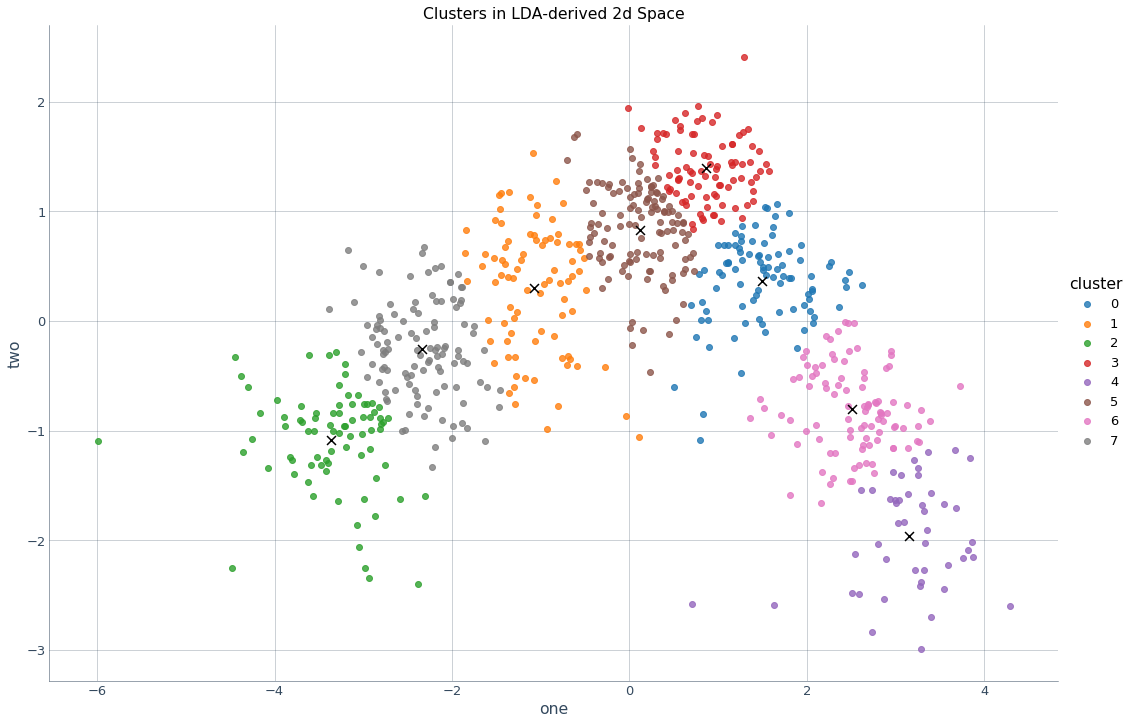

In [157]:
sns.lmplot('one', 'two', data = data, hue = 'cluster', fit_reg = False, height = 10, aspect = 1.5)
plt.scatter(centroid_x, centroid_y, marker = 'x', s = 80, c = 'black')
plt.title('Clusters in LDA-derived 2d Space')

plt.show()

In [168]:
cluster_num = 5

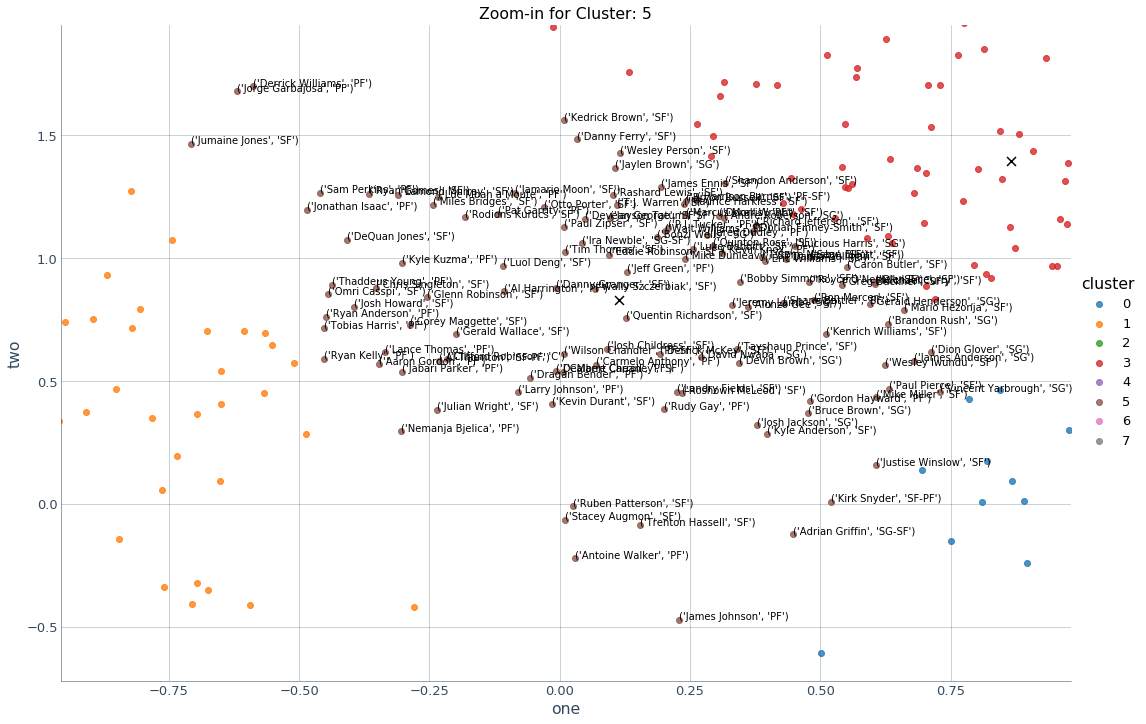

Importance  Cluster Average  League Average  Relative Difference
Cluster Feature                                                                     
5       3P_A         -0.334275         0.297843        0.241554             0.233030
        3PAr         -0.334273         0.297848        0.241557             0.233034
        Dist.        -0.317147        13.458348       12.144599             0.108176
        3PA          -0.257441         4.699385        4.020625             0.168819
        Astd_3P      -0.137344         0.933102        0.867262             0.075917
        Astd_2P      -0.112209         0.597887        0.547255             0.092520
        Corner_3P%   -0.107261         0.350824        0.324639             0.080660
        DRtg         -0.060334       107.354146      106.964698             0.003641
        DRB          -0.031337         6.298023        6.663150             0.054798
        ORtg         -0.013682       102.797562      103.890968             0.010525
        16-3pt%      -0.009750         0.354627        0.357946             0.009272
        TS%           0.018628         0.514079        0.518508             0.008542
        16-3pt_A      0.020330         0.193701        0.180793             0.071393
        %Corner3_A    0.021230         0.355000        0.257542             0.378413
        10-16%        0.033607         0.353577        0.361339             0.021481
        BLK           0.036300         0.801273        1.062393             0.245785
        TRB           0.054390         8.304170        9.108466             0.088302
        3-10%         0.067281         0.349968        0.360835             0.030116
        AST           0.116443         3.107413        4.252184             0.269219
        0-3%          0.121118         0.607658        0.602857             0.007965
        FGA           0.125635        16.038182       16.373641             0.020488
        PTS           0.140429        18.406691       19.148666             0.038748
        Dunk%         0.148353         0.049522        0.055888             0.113895
        ORB           0.149148         2.007126        2.445009             0.179092
        STL           0.153159         1.591858        1.588224             0.002289
        10-16_A       0.170118         0.099117        0.109387             0.093885
        3-10_A        0.179852         0.127221        0.152907             0.167986
        Dunks_Md      0.185510        20.785204       21.941772             0.052711
        FTr           0.191152         0.242737        0.280484             0.134577
        TOV           0.206829         2.415181        2.860691             0.155735
        0-3_A         0.221560         0.282089        0.315267             0.105240
        2PA           0.288734        11.338425       12.352181             0.082071
        2P_A          0.334273         0.702162        0.758449             0.074213

In [169]:
# cluster to inspect

cluster_list = []

league = data.drop(['Pos', 'one', 'two', 'cluster'], axis=1)

# return the stats with the least variance within each cluster, i.e. the common stats to a cluster

for i in range(n):

    cluster_df = data[data.cluster == i].drop(
        ['Pos', 'one', 'two', 'cluster'], axis=1)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_df)

    pca = PCA(n_components=2)
    PCA_reduced_df = pca.fit(scaled_data).transform(scaled_data)

    features = pd.DataFrame(list(zip(cluster_df.columns, pca.components_[0], np.mean(cluster_df), np.mean(league))),
                            columns=['Feature', 
                                     'Importance', 
                                     'Cluster Average', 
                                     'League Average']).sort_values('Importance')
    features['Cluster'] = i
    features['Relative Difference'] = np.abs(
        1 - (features['Cluster Average']/features['League Average']))
    features = features[['Cluster', 'Feature', 'Importance',
                         'Cluster Average', 'League Average', 'Relative Difference']]
    features = features.reset_index().drop('index', axis=1)

    cluster_list.append(features)

feature_importance = pd.concat(
    cluster_list).reset_index().drop('index', axis=1)

###################################################################################################################

names = data.index
positions = data['Pos']

sns.lmplot('one', 'two', data = data, hue = 'cluster', fit_reg = False, height = 10, aspect = 1.5)
plt.scatter(centroid_x, centroid_y, marker='x', s=80, c='black')
for i, name in enumerate(zip(names, positions)):
    x = data.reset_index().one[i]
    y = data.reset_index().two[i]
    if data.reset_index().loc[i, 'cluster'] == cluster_num:
        plt.text(x, y, name, fontsize=10)

# set zoom for cluster

xhigh = max(data[data.cluster == cluster_num].one) + 0.25
xlow = min(data[data.cluster == cluster_num].one) - 0.25
yhigh = max(data[data.cluster == cluster_num].two) + 0.25
ylow = min(data[data.cluster == cluster_num].two) - 0.25

plt.xlim([xlow, xhigh])
plt.ylim([ylow, yhigh])

plt.title('Zoom-in for Cluster: ' + str(cluster_num))
plt.show()

feature_importance[feature_importance.Cluster ==
                   cluster_num].set_index(['Cluster', 'Feature'])

### Cluster Descriptions
- Cluster 3: 'Floor General' 
- Cluster 5: 'Combo Guard' 
- Cluster 1: 'Two Way Threat' 
- Cluster 7: 'Lockdown' 
- Cluster 2: 'Slasher Shot Creator' 
- Cluster 6: 'Scoring Forward'
- Cluster 0: 'Skilled Big'
- Cluster 4: 'Rim Protector'

In [170]:
Label = data[['Pos','cluster']]
Label['cluster'] = Label['cluster'].map({4: 'Floor General', 
                                         6: 'Combo Guard',
                                         0: 'Two Way Threat',
                                         3: 'Lockdown',
                                         5: 'Slasher Shot Creator', 
                                         1: 'Scoring Forward',
                                         7: 'Skilled Big', 
                                         2: 'Rim Protector'})

## 3.3 Save Processed Data

In [127]:
players.describe()

,Year,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,salary,Dist.,2P_A,0-3_A,3-10_A,10-16_A,16-3pt_A,3P_A,0-3%,3-10%,10-16%,16-3pt%,Astd_2P,Dunk%,Dunks_Md,Astd_3P,%Corner3_A,Corner_3P%,Heaves_A,Heaves_Md
count,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10196.000000,10219.000000,10219.000000,8643.000000,10219.000000,10219.000000,10153.000000,10219.000000,10219.000000,9761.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10198.000000,10196.000000,10196.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10208.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,10219.000000,9.632000e+03,10196.000000,10196.000000,10196.000000,10196.000000,10196.000000,10196.000000,10196.000000,9927.000000,9705.000000,9513.000000,9591.000000,9999.000000,10196.000000,10219.000000,7234.000000,8643.000000,7314.000000,10219.000000,10219.000000
mean,2009.427635,26.706233,47.314414,22.179274,1095.701243,7.029122,16.357422,0.430874,1.314121,3.967326,0.282296,5.715099,12.389383,0.458715,3.285458,4.549134,0.724592,2.532479,6.474342,9.006625,4.112046,1.583883,1.030766,2.934837,5.143850,18.658088,101.698699,106.904981,12.372903,0.505962,0.235245,0.293752,5.579235,14.321930,9.949065,12.760397,1.583805,1.552451,14.055878,18.599158,1.136452,1.095274,2.232939,0.066508,-1.797182,-0.534808,-2.332087,0.497622,4.429488e+06,12.152864,0.764761,0.314650,0.151829,0.107976,0.190060,0.235244,0.592140,0.353018,0.355561,0.354368,0.543073,0.054312,16.378804,0.858013,0.262783,0.340159,0.782073,0.019963
std,5.476129,4.202662,26.309778,27.605683,888.760633,2.707074,5.077051,0.100915,1.458938,3.757291,0.161427,2.752028,4.993332,0.106380,2.201627,2.941792,0.151946,2.342251,2.983167,4.549660,2.952603,0.993408,1.180180,1.604669,2.455294,7.009034,17.606454,4.689944,6.434438,0.100976,0.212738,0.231710,5.041780,6.588986,5.035238,9.326845,0.993199,1.765192,6.860508,5.314898,1.913853,1.149220,2.795600,0.104783,3.828059,2.265352,4.651136,1.251883,5.046613e+06,5.014380,0.212736,0.183268,0.111322,0.082699,0.135642,0.212737,0.142756,0.165357,0.176158,0.158649,0.209654,0.078025,28.023773,0.191654,0.212770,0.202381,1.431057,0.146709
min,2000.000000,18.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,-54.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.300000,-0.600000,-2.100000,-1.521000,-48.100000,-23.100000,-59.000000,-2.200000,2.013300e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,23.000000,23.000000,0.000000,283.000000,5.400000,13.000000,0.392000,0.000000,0.200000,0.214000,3.900000,9.000000,0.420000,1.900000,2.600000,0.658000,0.900000,4.400000,5.500000,2.000000,1.100000,0.300000,2.100000,3.600000,14.400000,96.000000,104.000000,9.400000,0.473000,0.013750,0.171750,2.000000,9.700000,6.100000,6.200000,1.100000,0.400000,10.500000,15.000000,0.000000,0.200000,0.200000,0.031000,-3.400000,-1.700000,-4.200000,-0.200000,1.000000e+06,8.400000,0.609000,0.187750,0.077000,0.056000,0.087000,0.013750,0.533000,0.283000,0.280000,0.300000,0.400000,0.000000,0.000000,0.794000,0.115000,0.250000,0.000000,0.000000
50%,2010.000000,26.000000,51.000000,7.000000,903.000000,6.900000,16.100000,0.434000,1.000000,3.600000,0.325000,5.500000,12.000000,0.465000,2.900000,4.100000,0.750000,1.900000,6.000000,8.100000,3.200000,1.500000,0.600000,

In [171]:
fulldf = players[(players.Year > 1999) & (players.GS > 10)].drop('Pos', axis = 1).reset_index()

print(Label.shape)
print(fulldf.shape)

new_positions = pd.merge(Label.reset_index(), fulldf, on = 'Full Name', how = 'right').set_index('Full Name')

print(new_positions.shape)

(724, 2)
(4670, 73)
(4670, 74)


In [172]:
file_loc = 'data/interim/player_labels.csv'

Label.to_csv(file_loc)

file_loc2 = 'data/processed/players_final.csv'

new_positions.to_csv(file_loc2) # updated player info with new clusters on every player season

# 4 Results

Review of results here.

## 4.1 New Positions Histogram

In [173]:
final = data[:]
final['cluster'] = final['cluster'].map({4: 'Floor General', 
                                         6: 'Combo Guard',
                                         0: 'Two Way Threat',
                                         3: 'Lockdown',
                                         5: 'Slasher Shot Creator', 
                                         1: 'Scoring Forward',
                                         7: 'Skilled Big', 
                                         2: 'Rim Protector'})

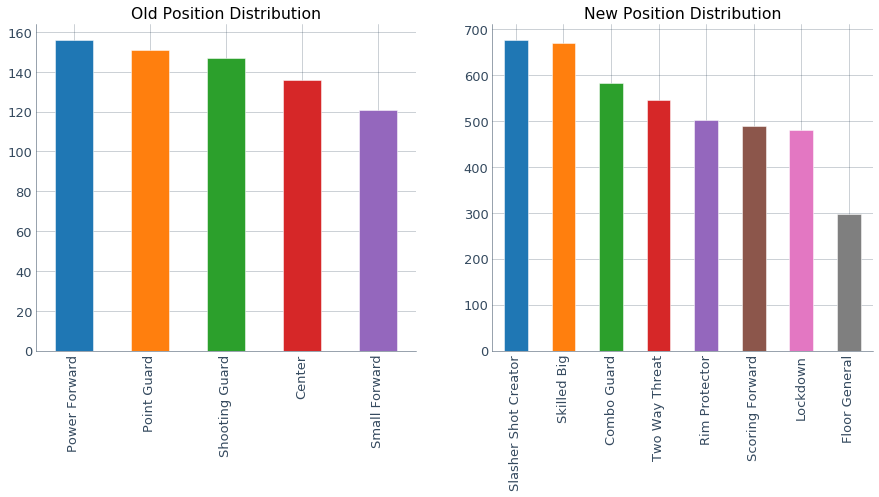

In [174]:
# new position hist

plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
plt.subplot(121)
ax = starters['Pos'].value_counts()[:5].plot(kind = 'bar')
ax.set_xticklabels(['Power Forward','Point Guard','Shooting Guard','Center','Small Forward'], rotation=90)
plt.title('Old Position Distribution')

plt.subplot(122)
new_positions.cluster.value_counts().plot(kind = 'bar')
plt.title('New Position Distribution')
plt.savefig('assets/clusters/new position distribution.png')
plt.show()

### 4.1.1 New Positions LDA

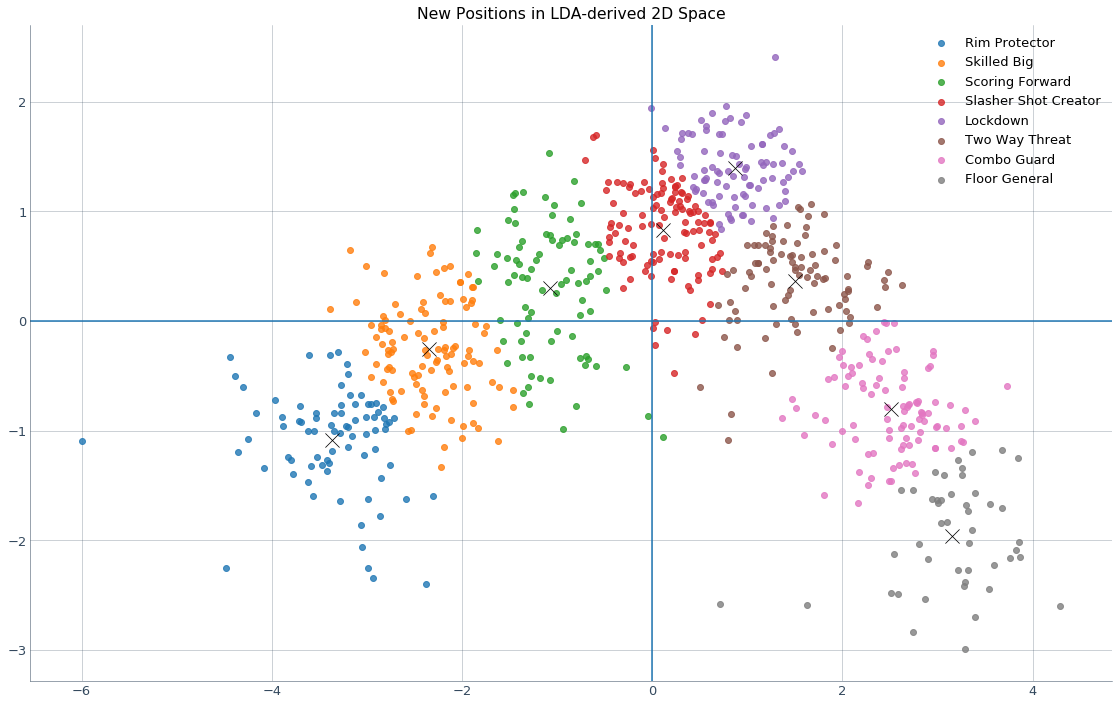

In [175]:
sns.lmplot('one', 'two', data = final, hue = 'cluster', fit_reg = False, height = 10, aspect = 1.6, legend = False)
sns.scatterplot(centroid_x, centroid_y, marker = 'x', s = 200, color = 'k')
plt.axvline(0)
plt.axhline(0)
plt.xlabel("")
plt.ylabel("")
plt.title('New Positions in LDA-derived 2D Space')
plt.savefig('assets/clusters/LDA New Positions.png')
plt.show()

## 4.2 Individual Cluster .png Files

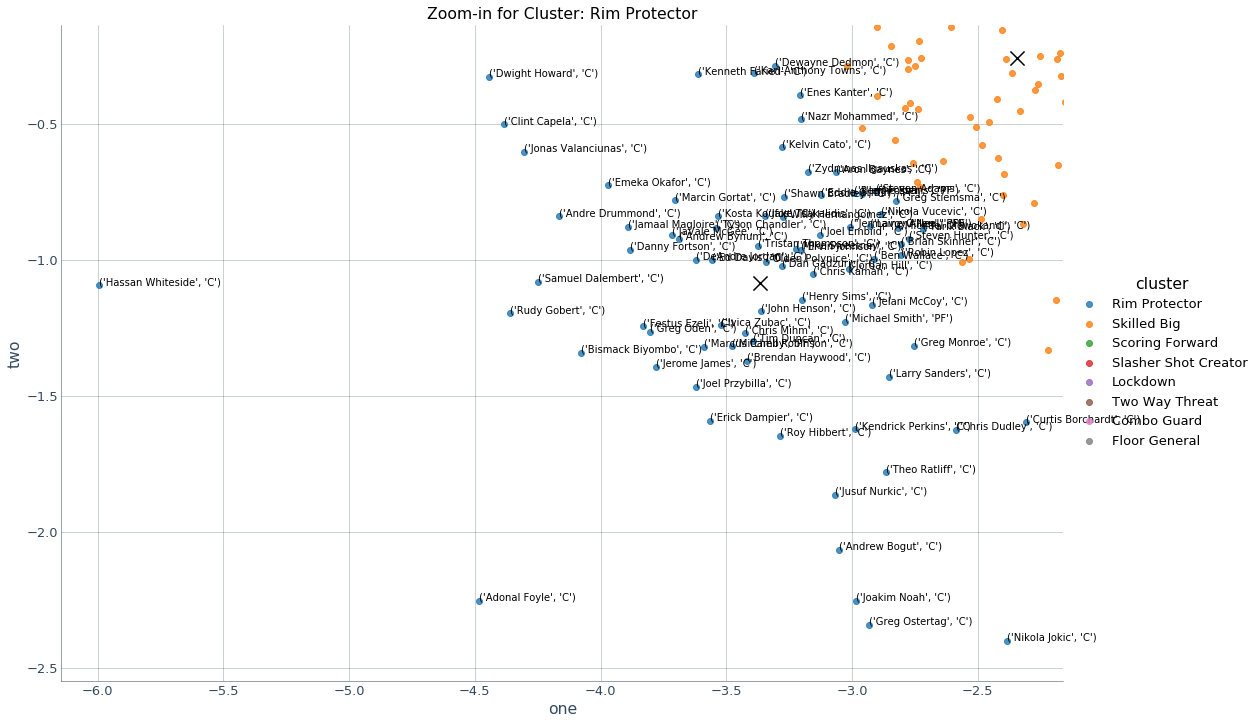

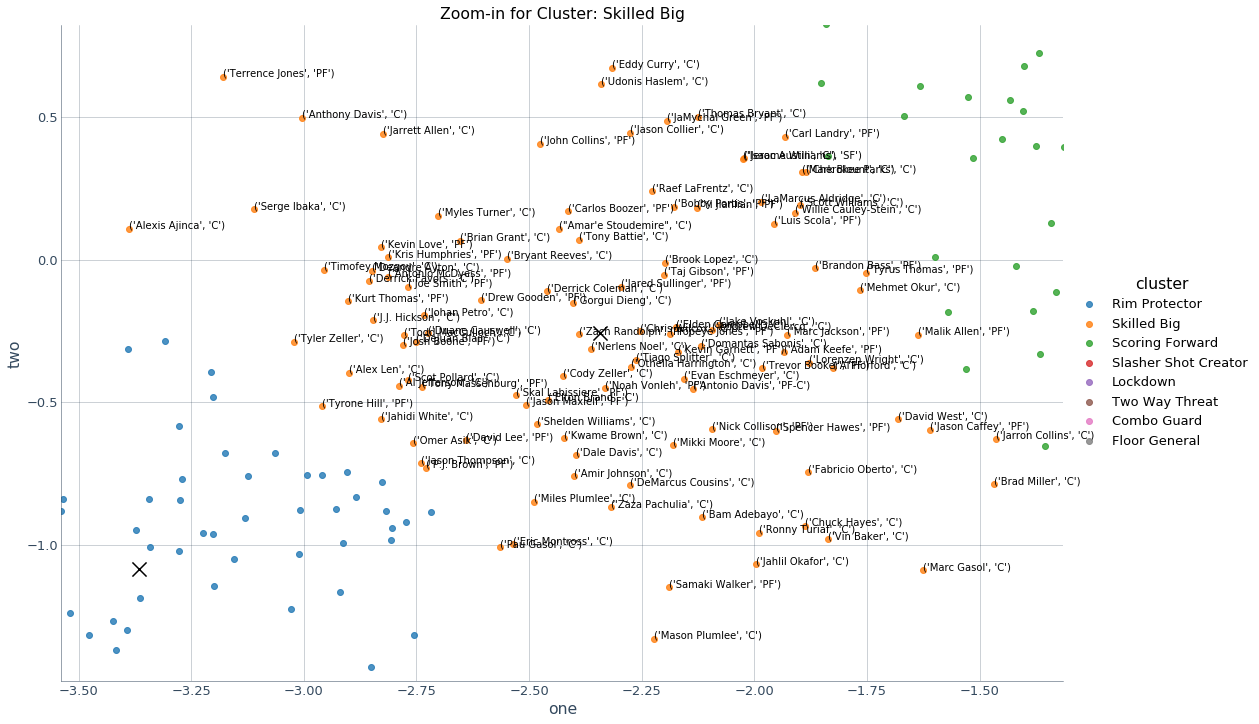

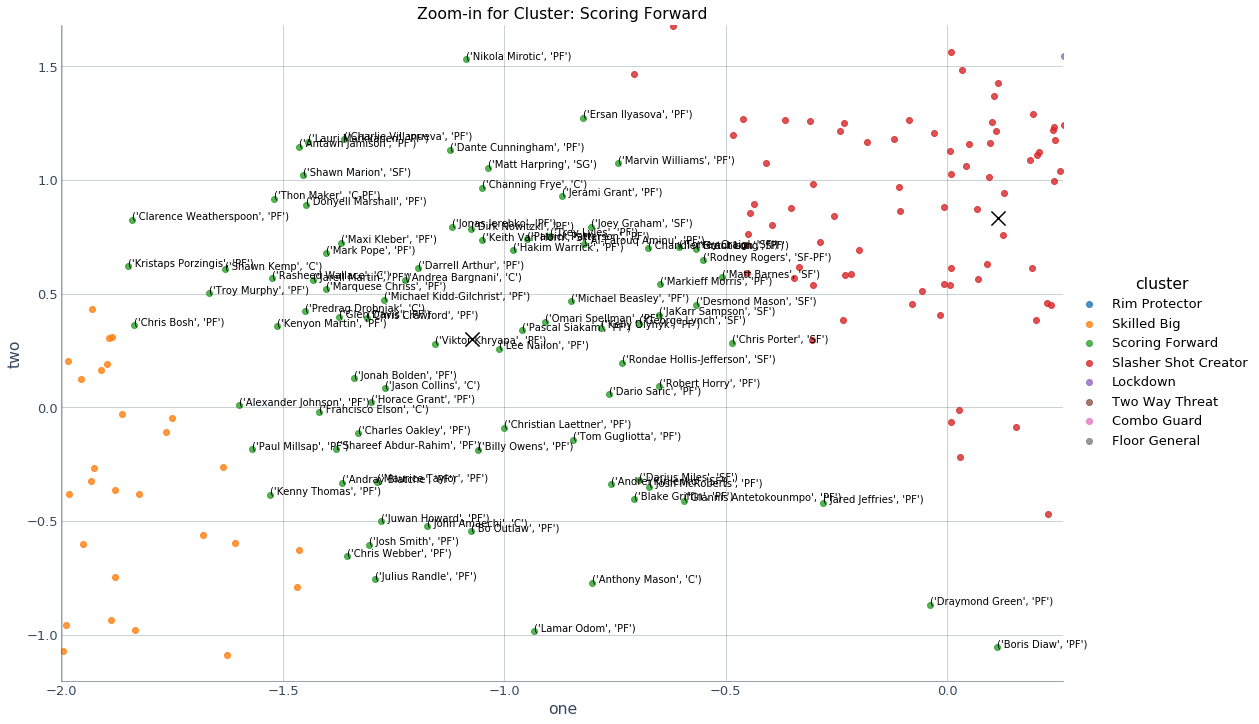

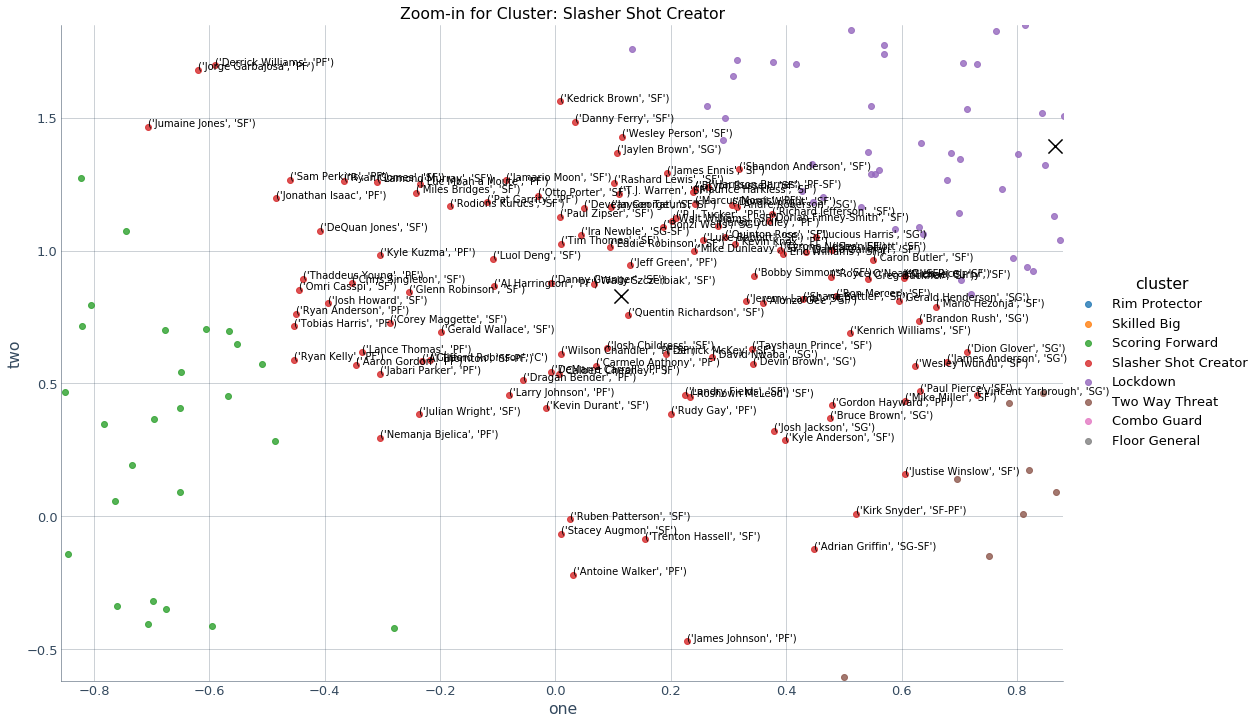

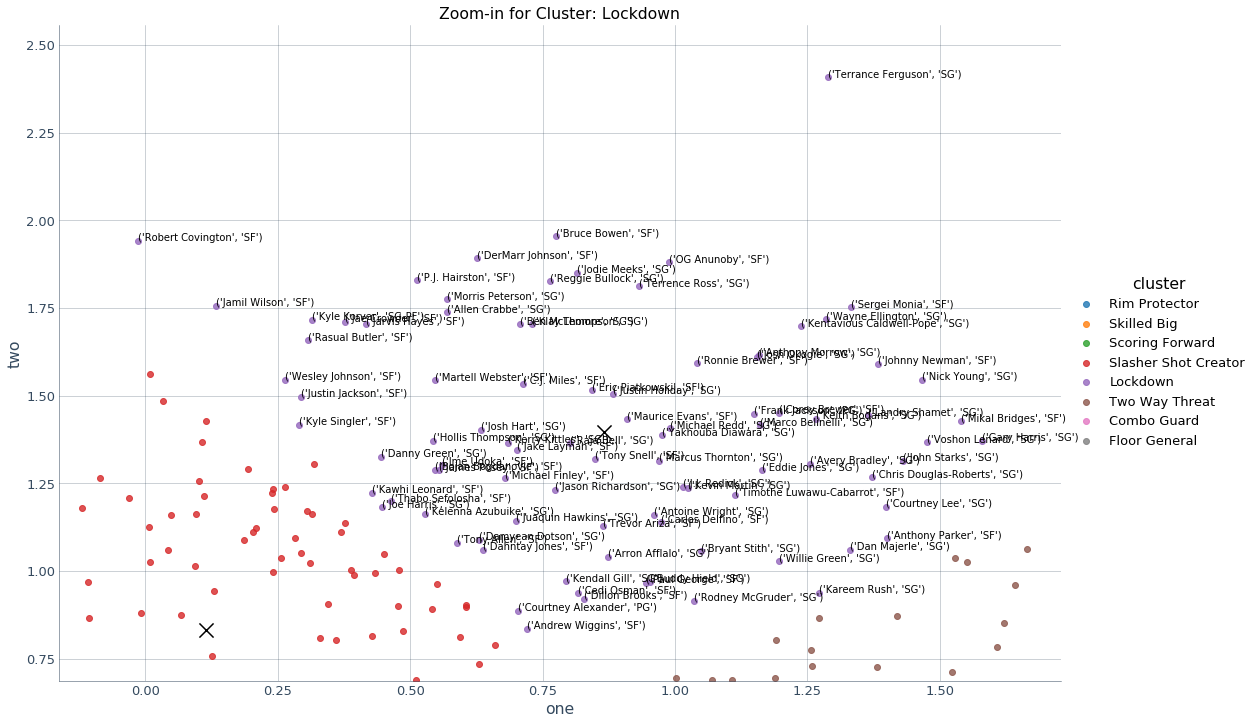

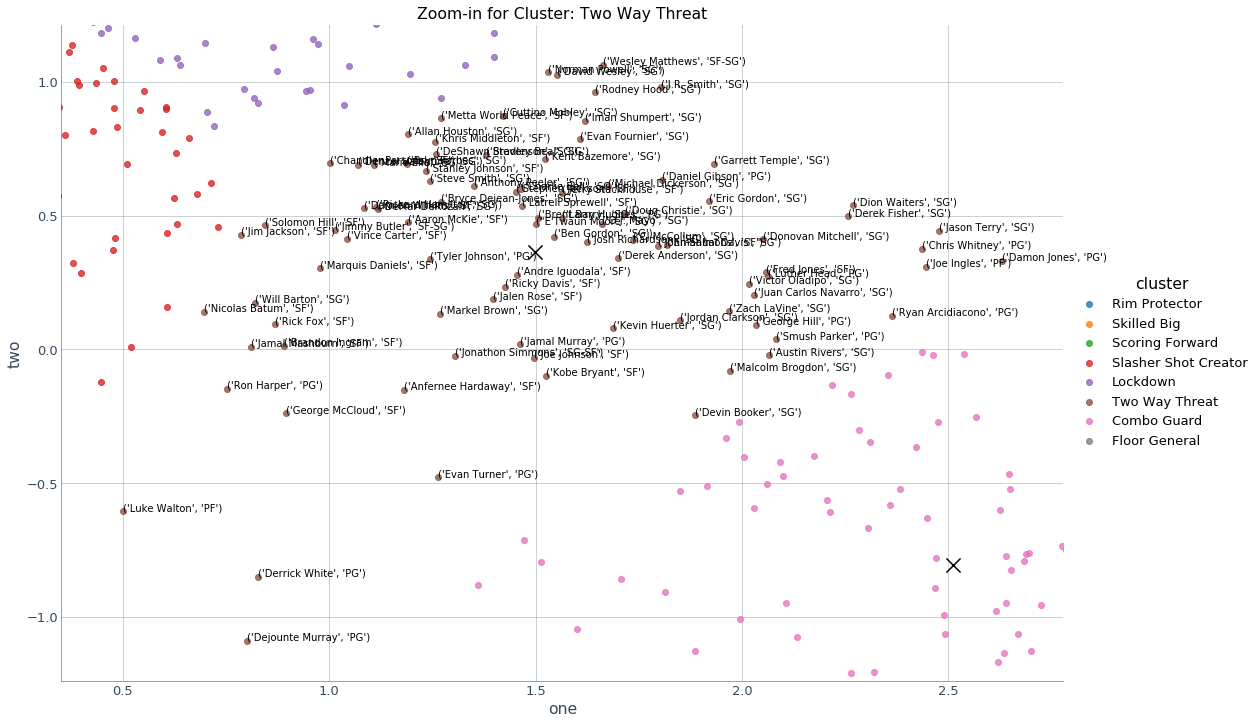

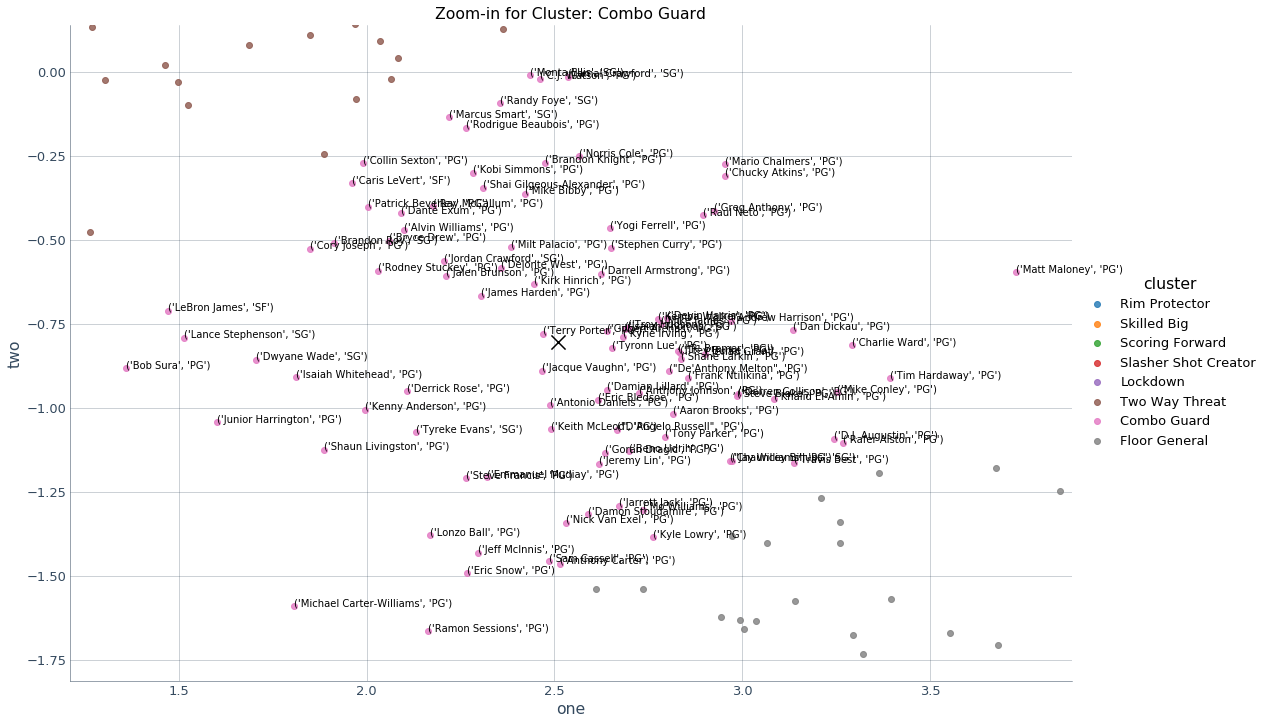

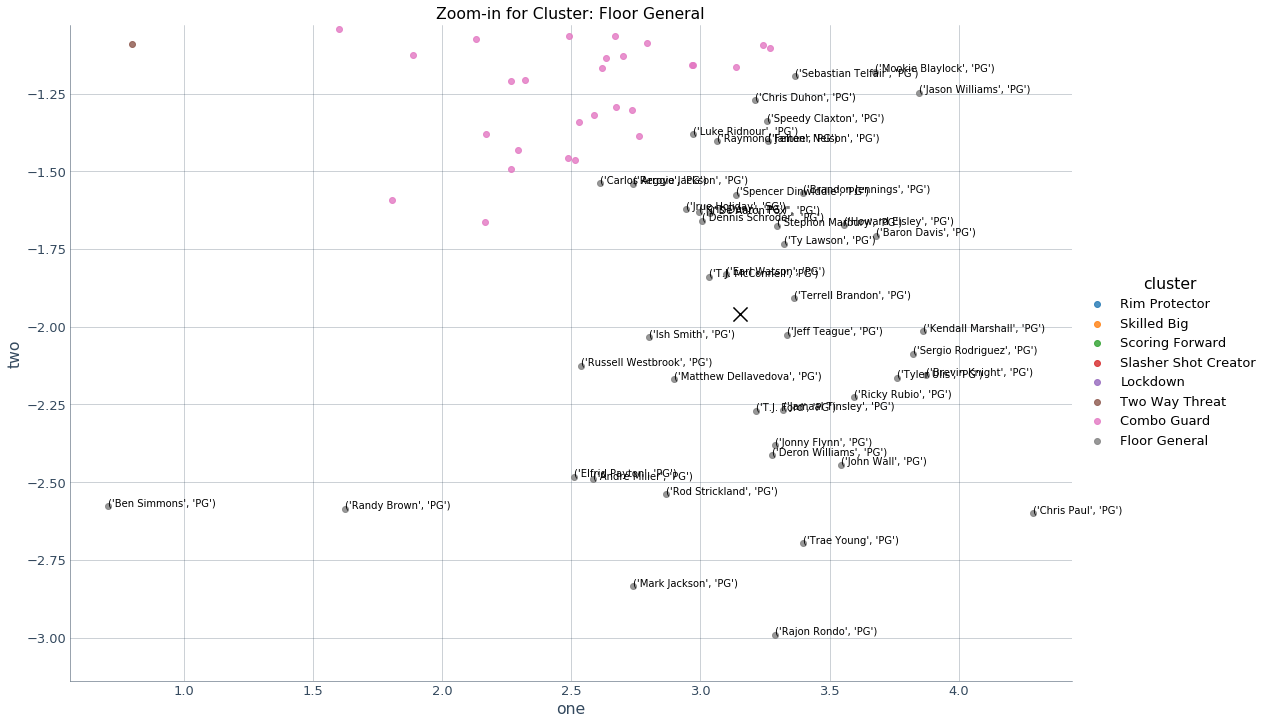

In [176]:
names = data.index
positions = data['Pos']
new_clusters = final.cluster.unique()
old_clusters = data.cluster.unique()

for i, j in zip(old_clusters, new_clusters):
    
    sns.lmplot('one', 'two', data=final, hue='cluster',
               fit_reg=False, height=10, aspect=1.5)
    plt.scatter(centroid_x, centroid_y, marker='x', s=200, c='black')
    for a, name in enumerate(zip(names, positions)):
        x = data.reset_index().one[a]
        y = data.reset_index().two[a]
        if data.reset_index().loc[a, 'cluster'] == i:
            plt.text(x, y, name, fontsize=10)

    # set zoom for cluster

    xhigh = max(data[data.cluster == i].one) + 0.15
    xlow = min(data[data.cluster == i].one) - 0.15
    yhigh = max(data[data.cluster == i].two) + 0.15
    ylow = min(data[data.cluster == i].two) - 0.15

    plt.xlim([xlow, xhigh])
    plt.ylim([ylow, yhigh])

    plt.title('Zoom-in for Cluster: {}'.format(j))
    plt.savefig('assets/clusters/{}'.format(j))

    plt.show()

In [177]:
compare = feature_importance[:]
compare.Cluster = compare.Cluster.map({4: 'Floor General', 
                                         6: 'Combo Guard',
                                         0: 'Two Way Threat',
                                         3: 'Lockdown',
                                         5: 'Slasher Shot Creator', 
                                         1: 'Scoring Forward',
                                         7: 'Skilled Big', 
                                         2: 'Rim Protector'})
compare = compare.iloc[:,[0,1]]

## 4.3 Feature Importance by Cluster

In [178]:
unique_clusters = pd.Series(compare.Cluster.unique())
unique_clusters

headers = ['Cluster', 'Stat 1', 'Stat 2', 'Stat 3', 'Stat 4', 'Stat 5','Stat 6']

clust_list = []
for i in range(0,80,10):

    clust = compare.iloc[range(i,i+8),1]
    clust_list.append(clust.reset_index())

features = pd.concat(clust_list, axis = 1).drop('index', axis = 1).T.reset_index().drop('index', axis = 1)

differences = pd.concat([unique_clusters, features], axis = 1)
differences = differences.iloc[:,[0,1,2,3,4,5,6]]
differences.columns = headers
differences

,Cluster,Stat 1,Stat 2,Stat 3,Stat 4,Stat 5,Stat 6
0,Two Way Threat,3PAr,3P_A,Dist.,3PA,DRtg,Corner_3P%
1,Scoring Forward,Astd_2P,Astd_3P,3-10%,0-3%,16-3pt_A,AST
2,Rim Protector,Dunk%,3-10_A,DRB,BLK,Dunks_Md,TOV
3,Lockdown,ORB,2PA,2P_A,2P_A,FTr,16-3pt_A
4,Floor General,3-10_A,TOV,STL,AST,%Corner3_A,Dunks_Md
5,Slasher Shot Creator,16-3pt%,FGA,3-10%,PTS,BLK,DRtg
6,Combo Guard,ORtg,Astd_3P,Dist.,3PA,3P_A,3PAr
7,Skilled Big,ORB,Dunks_Md,Astd_2P,BLK,ORtg,STL
